# imports

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

2.0.0
True


In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

# config

In [2]:
data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/spectrograms/spectrograms'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
img_height = 128#480
img_width = 128#640
batch_size = 4

# get dataset

In [3]:
def decode_str_tensor(tensor):
    return bytes.decode(tensor.numpy())

def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/spectrograms/spectrograms/train/sick/audioset_0CroKP1sYVw_15_20.png')

<tf.Tensor: id=67, shape=(), dtype=int64, numpy=0>

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    img = img/255
    return img, label
img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/spectrograms/spectrograms/train/sick/audioset_0CroKP1sYVw_15_20.png')
stats(img.numpy())

mean:0.6585096 max:1.0 min:0.11764706 median:0.597549 std:0.31823218 shape:(128, 128, 3) dtype:float32


In [6]:
def get_dataset(path):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache().shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = get_dataset(train_path)
test_ds = get_dataset(test_path)
val_ds = get_dataset(val_path)
train_ds

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (4, 128, 128, 3)
Label:  [1 1 1 1]


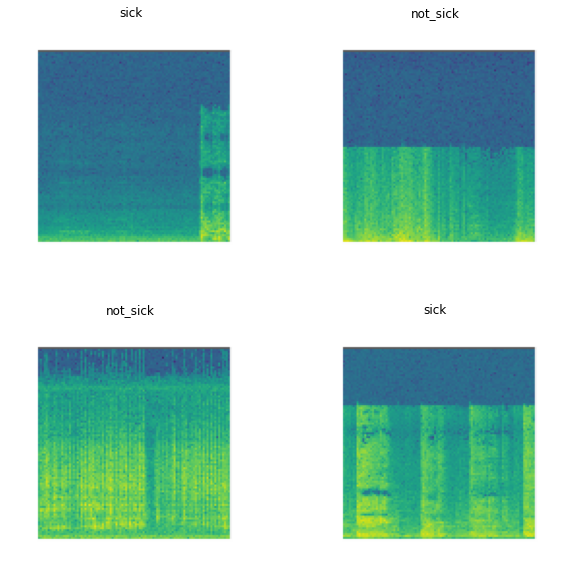

In [8]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow((image_batch[i].numpy()*255).astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model

In [9]:
model = tf.keras.Sequential([
    layers.Input(shape=[img_height, img_width, 3]),
    
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(1)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 64)        0

# train

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
929/929 [==============================] - 75s 80ms/step - loss: 0.6895 - accuracy: 0.5436 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
929/929 [==============================] - 5s 5ms/step - loss: 0.6102 - accuracy: 0.5961 - val_loss: 0.5844 - val_accuracy: 0.5972
Epoch 3/30
929/929 [==============================] - 5s 5ms/step - loss: 0.5929 - accuracy: 0.6292 - val_loss: 0.6060 - val_accuracy: 0.6079
Epoch 4/30
929/929 [==============================] - 5s 6ms/step - loss: 0.5732 - accuracy: 0.6507 - val_loss: 0.5643 - val_accuracy: 0.6308
Epoch 5/30
929/929 [==============================] - 5s 5ms/step - loss: 0.5424 - accuracy: 0.6876 - val_loss: 0.5214 - val_accuracy: 0.7137
Epoch 6/30
929/929 [==============================] - 5s 6ms/step - loss: 0.5217 - accuracy: 0.6994 - val_loss: 0.5091 - val_accuracy: 0.7473
Epoch 7/30
929/929 [==============================] - 5s 5ms/step - loss: 0.5073 - accuracy: 0.7061 - val_loss: 0.5361 - val_accuracy: 0.6

In [ ]:
model.evaluate(test_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()